In [303]:
import sys
import cantera as ct
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

import phases
import feedstock as fs
import fuel as fu
import energy as en
import gasifier as gs

In [304]:
DHfo_liq = phases.Hfo['H2O(l)']*1E-6
DHfo_vap = phases.Hfo['H2O']*1E-6

def Mw(fuel):
    formula = fuel.get_fuel_formula()
    ashMW = fuel.fuelAshMW
    totalMass = 0
    for i, sp in enumerate(['C(gr)', 'H', 'O', 'N', 'S', 'CL']):
        moles = formula[i]
        mw = phases.Mw[sp]
        mass = moles * mw
        totalMass += mass
    totalMass += ashMW * formula[-1]
    return totalMass

coalUltimate = [78.4750, 3.9681, 16.0249, 0.7044, 0.7748, 0.0528] # % daf
coalAshWB = 0.128199 # fraction, w.b.
coalMoistWB = 0.02 # fraction, w.b.
coalHHV_WB = 24.727 # MJ/kg, w.b.
coalLHV_WB = 24.155 # MJ/kg, w.b.
ashMW = 80.7 # kg/kmol
ashHF = -788.92 # MJ/kmol
coalHF = -44.17 # MJ/kmol

coalHHV_DB = coalHHV_WB / (1 - coalMoistWB) # MJ/kg, d.b.
coalLHV_DB = coalLHV_WB / (1 - coalMoistWB) # MJ/kg, d.b.
coalAshDB = coalAshWB / (1 - coalMoistWB) # fraction, d.b.
coalMoistDB = coalMoistWB / (1 - coalMoistWB) # fraction, d.b.
ashComposition = [54.06, 6.57, 23.18, 6.85, 0.82, 1.6, 1.83, 0.5, 1.05, 3.54, 0] # % of ash
coal = fs.create_fuel_stream(10535, coalUltimate, coalAshDB, 0, HHV=coalHHV_DB, LHV=coalLHV_DB, ashComposition=ashComposition)
coal.fuelAshHF = ashHF
coal.fuelAshMW = ashMW
initialCarbon = coal.species_moles[phases.indices['C(gr)']] * phases.Mw['C(gr)']

In [305]:
def HHV(fuel, LHV):
    a = fuel.get_fuel_formula()[1]
    M = Mw(fuel)
    return LHV - a / (2*M) * (DHfo_liq - DHfo_vap)

def LHV(fuel, HHV):
    a = fuel.get_fuel_formula()[1]
    M = Mw(fuel)
    return HHV + a / (2*M) * (DHfo_liq - DHfo_vap)

In [306]:
riceHusk = fs.create_fuel_stream(1-0.0923, [37.18, 4.26, 31.29, 0.68, 0.15, 0], 17.21/(100-9.23), 9.23/(100-9.23), LHV=15.039)
riceHusk.fuelHHV = HHV(riceHusk, riceHusk.fuelLHV)
stoichO2MassRice = fs.create_O2_from_ER(riceHusk, 1.0).get_mass()
print(stoichO2MassRice)
sawdust = fs.create_fuel_stream(1-0.0479, [48.88, 6.29, 33.59, 1.70, 0.06, 0], 4.69/(100-4.79), 4.79/(100-4.79), LHV=18.313)
sawdust.fuelHHV = HHV(sawdust, sawdust.fuelLHV)
stoichO2MassSawdust = fs.create_O2_from_ER(sawdust, 1.0).get_mass()
print(stoichO2MassSawdust)
camphor = fs.create_fuel_stream(1-0.1229, [43.43, 4.84, 38.53, 0.32, 0.10, 0], 0.49/(100-12.29), 9.23/(100-12.29), LHV=17.482)
camphor.fuelHHV = HHV(camphor, camphor.fuelLHV)
stoichO2MassCamphor = fs.create_O2_from_ER(camphor, 1.0).get_mass()
print(stoichO2MassCamphor)

1.0171679509826141
1.4660655129210656
1.156801408647354


In [307]:
char_params = np.array([-111.1574, 3.9705, 0.0362, -7.1958, 3.0419, 1.2430, 0.1276, 1.1034, 1.4281])
methane_params = np.array([16.5264, 0.4982, -0.0304, 0.1739, 0.2148, -0.1864, -0.1186, -0.2192, -0.2552])

def char(ER, MC, T, C, H, O, ash):
    a = lambda i: char_params[i]
    return np.exp(a(0) + a(1)*ER + a(2)*MC + a(3)*((10**(-3))*T) + a(4)*((10**(-3))*T)**2 + a(5)*C + a(6)*H + a(7)*O +a(8)*ash)

def met(ER, MC, T, C, H, O, ash):
    b = lambda i: methane_params[i]
    return np.exp(b(0) + b(1)*ER + b(2)*MC + b(3)*((10**(-3))*T) + b(4)*((10**(-3))*T)**2 + b(5)*C + b(6)*H + b(7)*O +b(8)*ash)

In [308]:
oxygen = fs.create_O2_stream(0.4)
TT = np.arange(1000, 1400+1E-6, 10) # °C
outletList = []
for i, t in enumerate(TT):
    outlet = gs.gasify_isot(riceHusk, oxygen, t+273.15)
    outletList.append(outlet)

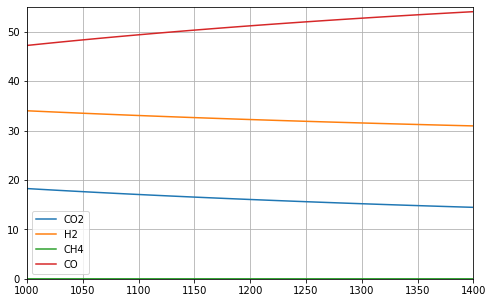

In [309]:
fig = plt.figure(figsize=(8,5))
species = ['CO2', 'H2', 'CH4', 'CO']
for i, sp in enumerate(species):
    plt.plot(TT, [100*out.get_syngas_fraction(sp, water=False, nitrogen=True) for out in outletList], label=sp)
plt.legend()
plt.xlim(TT[0], TT[-1])
plt.ylim(0,55)
plt.grid()
plt.show()

In [310]:
T = 1300 # °C
OB = np.arange(0, 1+1E-6, 0.05) # °C
outletList2 = []
for i, ob in enumerate(OB):
    oxy = fs.create_O2_stream(ob)
    outlet = gs.gasify_isot(riceHusk, oxy, T+273.15)
    outletList2.append(outlet)

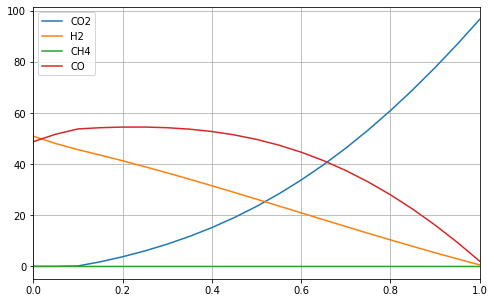

In [311]:
fig = plt.figure(figsize=(8,5))
species = ['CO2', 'H2', 'CH4', 'CO']
for i, sp in enumerate(species):
    plt.plot(OB, [100*out.get_syngas_fraction(sp, water=False, nitrogen=True) for out in outletList2], label=sp)
plt.legend()
plt.xlim(OB[0], OB[-1])
plt.grid()
plt.show()

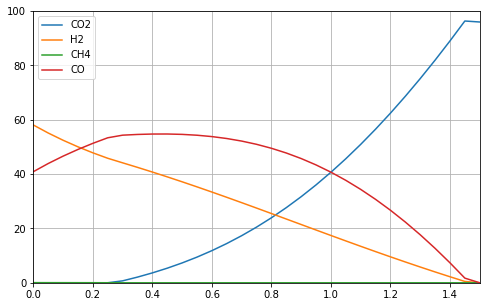

In [312]:
T = 1300 # °C
OB = np.arange(0, 1.5+1E-6, 0.05) # °C
outletList2 = []
for i, ob in enumerate(OB):
    oxy = fs.create_O2_stream(ob)
    outlet = gs.gasify_isot(sawdust, oxy, T+273.15)
    outletList2.append(outlet)

fig = plt.figure(figsize=(8,5))
species = ['CO2', 'H2', 'CH4', 'CO']
for i, sp in enumerate(species):
    plt.plot(OB, [100*out.get_syngas_fraction(sp, water=False, nitrogen=True) for out in outletList2], label=sp)
plt.legend()
plt.xlim(OB[0], OB[-1])
plt.ylim(0,100)
plt.grid()
plt.show()